In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

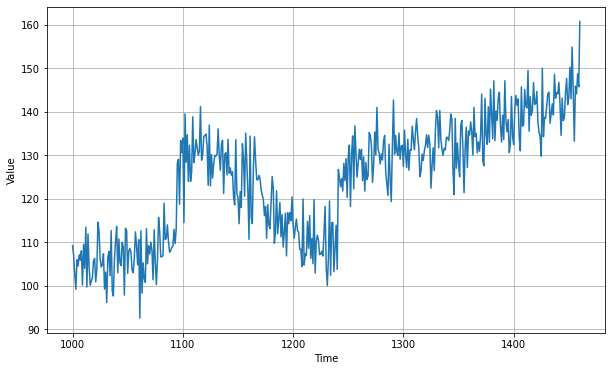

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 378.9134
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 72.3217
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 60.2740
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 58.9606
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 57.5012
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 56.8933
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 56.2816
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 55.4633
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 53.4181
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 53.9378
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 52.0605
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 51.7087
Epoch 13/100
31/31 [====

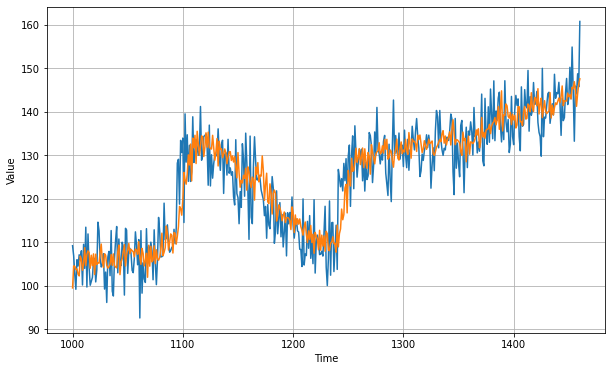

In [7]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7562895

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

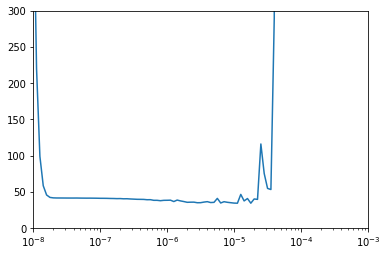

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [11]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=2)

Epoch 1/500
31/31 - 0s - loss: 500.1867
Epoch 2/500
31/31 - 0s - loss: 47.8531
Epoch 3/500
31/31 - 0s - loss: 49.0181
Epoch 4/500
31/31 - 0s - loss: 55.1287
Epoch 5/500
31/31 - 0s - loss: 43.0776
Epoch 6/500
31/31 - 0s - loss: 42.2420
Epoch 7/500
31/31 - 0s - loss: 51.1251
Epoch 8/500
31/31 - 0s - loss: 45.3950
Epoch 9/500
31/31 - 0s - loss: 39.7675
Epoch 10/500
31/31 - 0s - loss: 43.0953
Epoch 11/500
31/31 - 0s - loss: 38.1520
Epoch 12/500
31/31 - 0s - loss: 46.2675
Epoch 13/500
31/31 - 0s - loss: 42.5135
Epoch 14/500
31/31 - 0s - loss: 38.9707
Epoch 15/500
31/31 - 0s - loss: 42.7164
Epoch 16/500
31/31 - 0s - loss: 43.5056
Epoch 17/500
31/31 - 0s - loss: 37.2966
Epoch 18/500
31/31 - 0s - loss: 39.4070
Epoch 19/500
31/31 - 0s - loss: 38.9428
Epoch 20/500
31/31 - 0s - loss: 36.8630
Epoch 21/500
31/31 - 0s - loss: 40.6816
Epoch 22/500
31/31 - 0s - loss: 52.8967
Epoch 23/500
31/31 - 0s - loss: 40.2131
Epoch 24/500
31/31 - 0s - loss: 35.2230
Epoch 25/500
31/31 - 0s - loss: 38.1790
Epoch 26

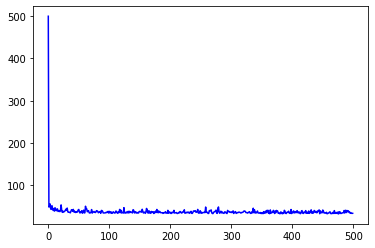

In [12]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[38.152008056640625, 46.26753616333008, 42.51353073120117, 38.970699310302734, 42.71641540527344, 43.505550384521484, 37.2966423034668, 39.4069938659668, 38.94278335571289, 36.863014221191406, 40.68156814575195, 52.89667892456055, 40.213104248046875, 35.2230110168457, 38.178955078125, 35.85573959350586, 36.91288757324219, 37.89111328125, 40.54764175415039, 42.89114761352539, 39.917388916015625, 45.323692321777344, 36.391632080078125, 35.30878448486328, 35.7739372253418, 35.06596374511719, 33.99534606933594, 37.090484619140625, 41.39258575439453, 41.34815216064453, 37.57767105102539, 42.205535888671875, 36.07603454589844, 38.14927291870117, 35.47175979614258, 34.868858337402344, 37.01896286010742, 35.24611282348633, 37.38593673706055, 40.802268981933594, 42.140323638916016, 35.73957061767578, 33.601165771484375, 36.92047119140625, 34.87781524658203, 39.12483215332031, 33.14873123168945, 37.08241653442383, 40.4447135925293, 33.810035705566406, 34.2864875793457, 49.700958251953125, 43.521

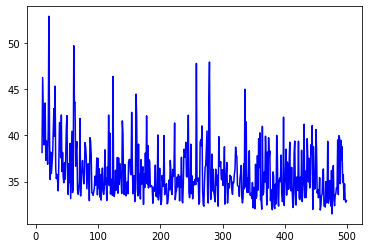

In [14]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

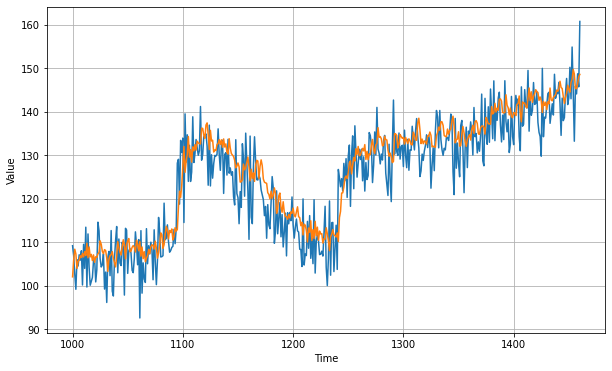

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.89466